# 01 理论与势能

目标：验证平均场分岔与势能形态，展示对称分支（q 正负）以及 r 对势阱的影响。


In [14]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


ROOT = Path.cwd()
if not (ROOT / 'src').exists() and (ROOT.parent / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import calculate_chi, calculate_rc, get_gl_params, potential_energy, SDEConfig, run_sde_simulation

phi, theta, k_avg = 0.54, 0.46, 50
n_m, n_w = 10, 5
seed = 0
output_dir = ROOT / 'outputs'
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / 'data'
data_dir.mkdir(exist_ok=True)
fig_root = output_dir / 'figs'
fig_root.mkdir(exist_ok=True)
fig_dir = fig_root / 'fig1'
fig_dir.mkdir(parents=True, exist_ok=True)
print(f"图输出目录: {fig_dir.resolve()}")

plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('text', usetex=False)
from scipy.stats import gaussian_kde


图输出目录: E:\newdesktop\emotion_dynamics\outputs\figs\fig1


In [15]:

chi = calculate_chi(phi=phi, theta=theta, k_avg=k_avg)
rc = float(calculate_rc(n_m=n_m, n_w=n_w, chi=chi))
print(f"chi={chi:.3f}, rc={rc:.3f}")


chi=9.596, rc=0.753


Saved: E:\newdesktop\emotion_dynamics\outputs\figs\fig1\fig1_bifurcation.png


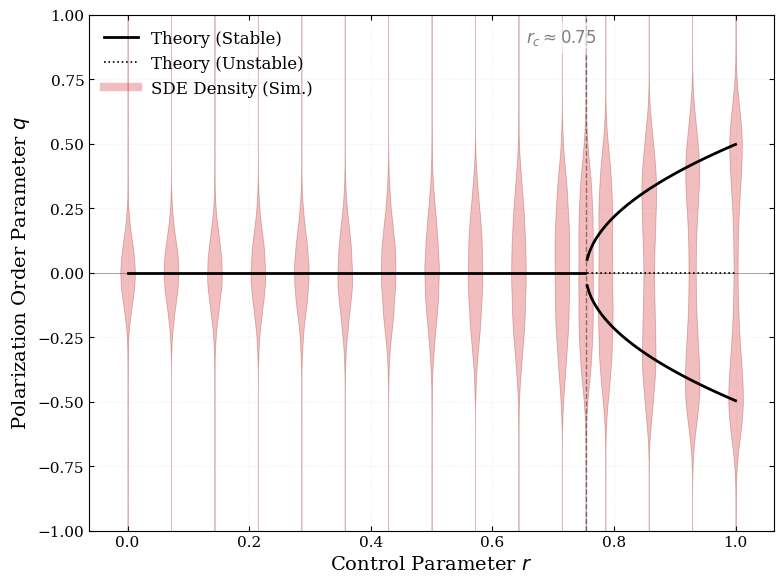

In [16]:

# Bifurcation with KDE density (refined styling)
# **改进的稳态采样**：
# - 取最后 20% 的轨迹时间点（而不是只取最后一个点）
# - 这样更能反映稳态概率分布，避免单点波动

# 为避免“跳过临界点”，把 rc 强制插入采样，并限制 r∈[0,1]
r_vals = np.sort(np.unique(np.concatenate([np.linspace(0, 1.0, 15), np.array([rc])])))
n_trajectories = 500  # 减少轨迹数，增加时间采样
steps = 20000
dt = 1e-2
sigma = 0.15
RECORD_INTERVAL = 100  # 每 100 步记录一次
STEADY_FRACTION = 0.2  # 取最后 20% 的时间点

q_min, q_max = -1.0, 1.0
q_grid = np.linspace(q_min, q_max, 300)
width_scale = 0.012  # narrower violins for whitespace

alpha_theory, u_val = get_gl_params(r=r_vals, rc=rc)
q_branch = np.where(alpha_theory < 0, np.sqrt(np.abs(alpha_theory) / u_val), 0)

r_dense = np.linspace(r_vals.min(), r_vals.max(), 300)
alpha_dense, _ = get_gl_params(r=r_dense, rc=rc)
q_dense = np.where(alpha_dense < 0, np.sqrt(np.abs(alpha_dense) / u_val), 0)

fig, ax = plt.subplots(figsize=(8, 6))

for idx, r in enumerate(r_vals):
    alpha, u = get_gl_params(r=r, rc=rc)
    cfg = SDEConfig(alpha=float(alpha), u=u, sigma=sigma, dt=dt, steps=steps, 
                    n_trajectories=n_trajectories, seed=seed + idx)
    _, traj = run_sde_simulation(cfg, q0=0.0, record_interval=RECORD_INTERVAL)
    # 取最后 20% 的时间点，展平为 1D 数组用于 KDE
    n_steady = max(1, int(traj.shape[0] * STEADY_FRACTION))
    steady_samples = traj[-n_steady:, :].flatten()
    endpoints = steady_samples  # 用于 KDE 的稳态样本
    kde = gaussian_kde(endpoints, bw_method='scott')
    density = kde(q_grid)
    if density.max() > 0:
        density = density / density.max() * width_scale
    x_left = r - density
    x_right = r + density
    ax.fill_betweenx(
        q_grid,
        x_left,
        x_right,
        color='#d62728',
        alpha=0.3,
        linewidth=0.6,
        edgecolor='#8c1b13',
        zorder=2,
    )

# Theory lines on top
stable_top, = ax.plot(r_dense[alpha_dense<0], q_dense[alpha_dense<0], color='black', linewidth=2.0, label='Theory (Stable)', zorder=5)
stable_bot, = ax.plot(r_dense[alpha_dense<0], -q_dense[alpha_dense<0], color='black', linewidth=2.0, zorder=5)
mask_stable0 = r_dense <= rc
ax.plot(r_dense[mask_stable0], np.zeros_like(r_dense[mask_stable0]), color='black', linewidth=2.0, zorder=5)
mask_unstable0 = r_dense > rc
unstable_line, = ax.plot(r_dense[mask_unstable0], np.zeros_like(r_dense[mask_unstable0]), color='black', linestyle=':', linewidth=1.2, label='Theory (Unstable)', zorder=5)

ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, zorder=1)
ax.axvline(rc, color='gray', linestyle='--', linewidth=1.0, zorder=1)
ax.text(rc - 0.04, q_max*0.95, fr'$r_c \approx {rc:.2f}$', ha='center', va='top', fontsize=12, color='gray', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

ax.set_xlabel(r'Control Parameter $r$')
ax.set_ylabel(r'Polarization Order Parameter $q$')
ax.set_ylim(q_min, q_max)
ax.tick_params(direction='in', top=True, right=True)
ax.grid(True, linestyle=':', alpha=0.2, linewidth=0.8, zorder=0)

handles = [stable_top, unstable_line, plt.Line2D([0],[0], color='#d62728', alpha=0.3, linewidth=6)]
labels = ['Theory (Stable)', 'Theory (Unstable)', 'SDE Density (Sim.)']
ax.legend(handles, labels, loc='upper left', frameon=False)

fig.tight_layout()
out_path = fig_dir / 'fig1_bifurcation.png'
fig.savefig(out_path, dpi=300)
print(f"Saved: {out_path.resolve()}")
plt.show()


In [17]:

# 使用 src.theory.potential_energy（已在上方导入），避免重复定义


Saved: E:\newdesktop\emotion_dynamics\outputs\figs\fig1\fig2_potential.png


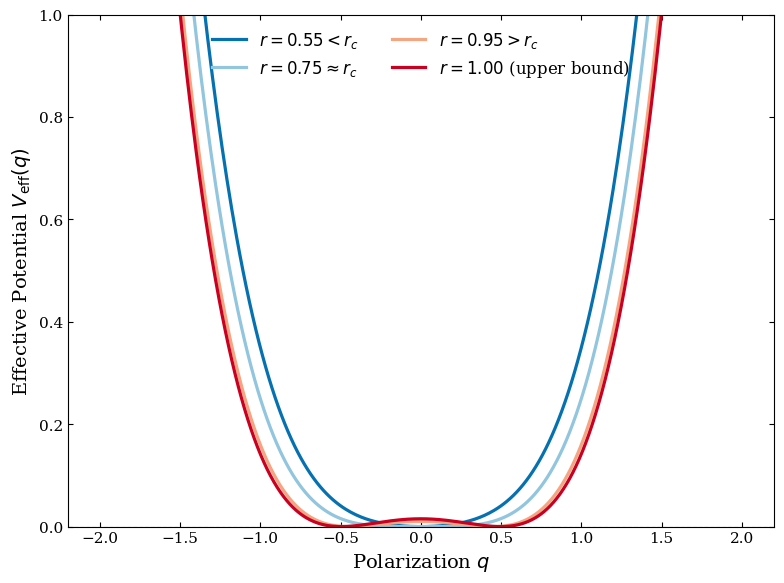

In [18]:

# Publication-quality potential landscape (no inset)
colors = ['#0571b0', '#92c5de', '#f4a582', '#ca0020']
r_samples = [max(rc - 0.2, 0.0), rc, min(rc + 0.2, 1.0), 1.0]
labels = [
    rf'$r = {r_samples[0]:.2f} < r_c$',
    rf'$r = {r_samples[1]:.2f} \approx r_c$',
    rf'$r = {r_samples[2]:.2f} > r_c$',
    rf'$r = {r_samples[3]:.2f}$ (upper bound)',
]
q_grid = np.linspace(-2.0, 2.0, 400)

fig, ax = plt.subplots(figsize=(8, 6))
for r, col, lab in zip(r_samples, colors, labels):
    alpha, u = get_gl_params(r=r, rc=rc)
    V = potential_energy(q_grid, alpha=float(alpha), u=u)
    V = V - V.min()
    ax.plot(q_grid, V, color=col, linewidth=2.3, label=lab)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel(r'Polarization $q$')
ax.set_ylabel(r'Effective Potential $V_{\mathrm{eff}}(q)$')
ax.set_ylim(0.0, 1.0)
ax.tick_params(direction='in', top=True, right=True)
ax.grid(False)
ax.legend(frameon=False, loc='upper center', ncol=2)

fig.tight_layout()
out_path = fig_dir / 'fig2_potential.png'
fig.savefig(out_path, dpi=300)
print(f"Saved: {out_path.resolve()}")
plt.show()


**结论**：
- 分岔图展示了对称分支，SDE 稳态分布在正负两支间分布，验证对称性破缺与理论 $r_c$ 的一致性。
- 势能图在 $r>r_c$ 时出现双势阱，且 $r$ 越大双阱越明显（与 GL 势能形态一致）。
- 附录（非对称扩展）：在 $p_{we}=(a+q)/2$ 耦合下，本次统计表现为 $\sigma_a<\sigma_q$ 但 $\tau_a\leq\tau_q$，不支持“$a$ 一定更慢”的绝热假设；准静态近似需绑定参数与窗口，或改为显式建模 $a$ 的动力学。



## 附录：检验 Activity $a$ 的准静态近似

**理论背景**：
在更一般的（非对称）机制中，$a$ 会耦合到 $p_{we}=(a+q)/2$，因此在推导/使用 $q$ 的有效势能时，常把 $a$ 视为“准静态参数”（在考察窗口内变化相对平缓）。
需要注意：靠近临界点时 $q$ 会出现临界慢化，未必存在严格的时间尺度分离（例如 $\tau_a \gg \tau_q$）。

**关键对齐**：
- 本验证以 `symmetric_mode=False` 为主（使 $a$ 真正进入 $p_{we}$）；并用 `symmetric_mode=True` 做基准对照（此时 $a$ 不进入 $p_{we}$，不应据此推断非对称情形）。
- 为避免“单次统计”造成反向结论，下面使用多 seed 汇总；幅度判据（$\sigma$）仅作参考，时间尺度判据（$\tau$）作为主结论。

**验证方法**：
通过 ABM 模拟，同时记录 $q(t)$ 和 $a(t)$；在丢弃 burn-in 后的稳态窗口中比较：
- 波动幅度（$\sigma_a$ vs $\sigma_q$，仅作参考）
- 自相关衰减时间（$\tau_a$ vs $\tau_q$，作为主判据）


rc_ref (symmetric theory) = 0.7533,  r = 0.6533 (rc_ref-0.10)
N=1000, beta=0.0, update_rate=0.1, steps=2000, record_interval=1

[Asymmetric (symmetric_mode=False)] seeds=10
σ_q: 0.0206 ± 0.0006
σ_a: 0.0107 ± 0.0006
mean(σ_q/σ_a): 1.93
τ_q: 9.0 ± 1.7 steps (1/e)
τ_a: 6.1 ± 0.7 steps (1/e)
mean(τ_a/τ_q): 0.70
结论（基于本次多 seed 稳态窗口统计）:
- σ_a<σ_q 的 seed 占比: 100%  （幅度仅作参考）
- τ_a>τ_q 的 seed 占比: 0%  （时间尺度主判据）
- 两者同时满足的 seed 占比: 0%

[Symmetric baseline (symmetric_mode=True)] seeds=10
σ_q: 0.0235 ± 0.0009
σ_a: 0.0143 ± 0.0008
mean(σ_q/σ_a): 1.64
τ_q: 8.2 ± 0.8 steps (1/e)
τ_a: 9.4 ± 1.1 steps (1/e)
mean(τ_a/τ_q): 1.15
结论（基于本次多 seed 稳态窗口统计）:
- σ_a<σ_q 的 seed 占比: 100%  （幅度仅作参考）
- τ_a>τ_q 的 seed 占比: 70%  （时间尺度主判据）
- 两者同时满足的 seed 占比: 70%


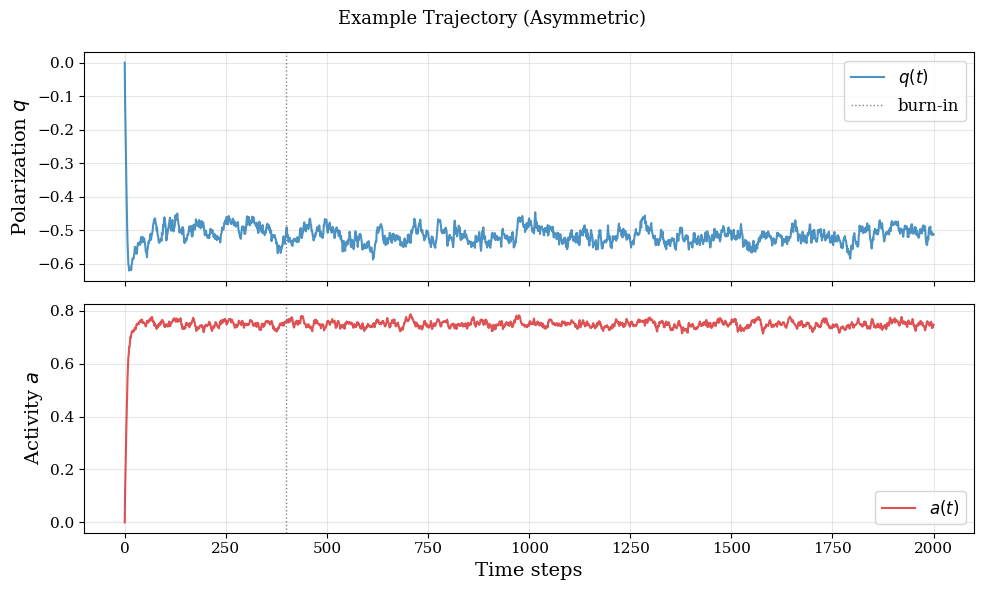

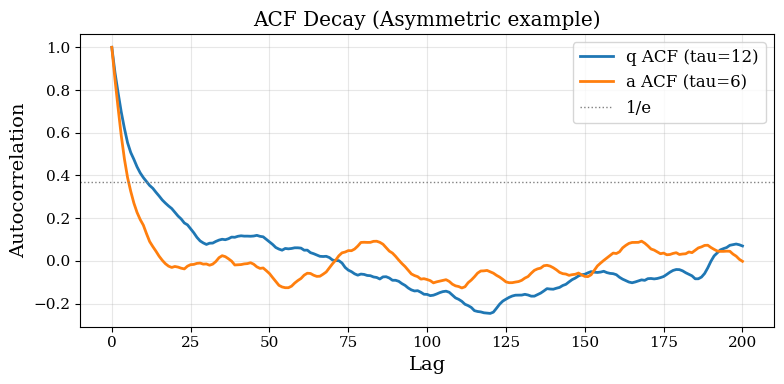

In [19]:

# 检验 Activity a 的慢变/准静态假设（非对称耦合为主，多 seed 汇总）
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.network_sim import NetworkAgentModel, NetworkConfig
from src import calculate_chi, calculate_rc


# -----------------------------
# 实验参数（可按需调整）
# -----------------------------
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5
k_avg = 50

N = 1000
beta = 0.0
update_rate = 0.1
init_state = "medium"

steps = 2000
record_interval = 1
burn_in_frac = 0.2
max_lag = 200

seeds = list(range(10))

# 选取 r：用对称理论的 rc 作为参考坐标（非对称下 rc 不再严格可比）
chi = calculate_chi(phi, theta, k_avg)
rc_ref = float(calculate_rc(n_m, n_w, chi))
r = float(np.clip(rc_ref - 0.1, 0.0, 1.0))

print(f"rc_ref (symmetric theory) = {rc_ref:.4f},  r = {r:.4f} (rc_ref-0.10)")
print(f"N={N}, beta={beta}, update_rate={update_rate}, steps={steps}, record_interval={record_interval}")

burn_step = steps * burn_in_frac


def acf_1e_decay_time(x: np.ndarray, max_lag: int = 200):
    # 估算自相关衰减到 1/e 的 lag（先去均值），并返回 ACF(0..max_lag)
    x = np.asarray(x, dtype=float)
    x = x - np.mean(x)
    if x.size < 2:
        return 0, np.ones(max_lag + 1, dtype=float)

    acf_full = np.correlate(x, x, mode="full")
    start = x.size - 1
    acf = acf_full[start : start + max_lag + 1]
    if acf[0] == 0:
        return 0, np.zeros_like(acf)

    acf = acf / acf[0]
    idx = np.where(acf < 1 / np.e)[0]
    tau = int(idx[0]) if len(idx) else int(max_lag)
    return tau, acf


def run_one(seed: int, symmetric_mode: bool):
    cfg = NetworkConfig(
        n=N,
        avg_degree=k_avg,
        model="er",
        beta=beta,
        update_rate=update_rate,
        r=r,
        n_m=n_m,
        n_w=n_w,
        phi=phi,
        theta=theta,
        seed=seed,
        init_state=init_state,
        sample_mode="fixed",
        sample_n=k_avg,
        symmetric_mode=symmetric_mode,
    )
    model = NetworkAgentModel(cfg)
    t, q_traj, a_traj = model.run(steps=steps, record_interval=record_interval)
    mask = t >= burn_step
    q_eval = q_traj[mask]
    a_eval = a_traj[mask]
    return t, q_traj, a_traj, q_eval, a_eval


def summarize_mode(symmetric_mode: bool, label: str):
    sigma_q_list, sigma_a_list = [], []
    tau_q_list, tau_a_list = [], []

    example = None

    for seed in seeds:
        t, q_traj, a_traj, q_eval, a_eval = run_one(seed=seed, symmetric_mode=symmetric_mode)

        sigma_q_list.append(float(np.std(q_eval)))
        sigma_a_list.append(float(np.std(a_eval)))

        tau_q, _ = acf_1e_decay_time(q_eval, max_lag=max_lag)
        tau_a, _ = acf_1e_decay_time(a_eval, max_lag=max_lag)
        tau_q_list.append(int(tau_q))
        tau_a_list.append(int(tau_a))

        if example is None:
            example = (t, q_traj, a_traj, q_eval, a_eval)

    sigma_q = np.asarray(sigma_q_list, dtype=float)
    sigma_a = np.asarray(sigma_a_list, dtype=float)
    tau_q = np.asarray(tau_q_list, dtype=float)
    tau_a = np.asarray(tau_a_list, dtype=float)

    ratio_sigma = sigma_q / np.where(sigma_a == 0, np.nan, sigma_a)
    ratio_tau = tau_a / np.where(tau_q == 0, np.nan, tau_q)

    print(f"\n[{label}] seeds={len(seeds)}")
    print(f"σ_q: {sigma_q.mean():.4f} ± {sigma_q.std(ddof=1):.4f}")
    print(f"σ_a: {sigma_a.mean():.4f} ± {sigma_a.std(ddof=1):.4f}")
    print(f"mean(σ_q/σ_a): {np.nanmean(ratio_sigma):.2f}")
    print(f"τ_q: {tau_q.mean():.1f} ± {tau_q.std(ddof=1):.1f} steps (1/e)")
    print(f"τ_a: {tau_a.mean():.1f} ± {tau_a.std(ddof=1):.1f} steps (1/e)")
    print(f"mean(τ_a/τ_q): {np.nanmean(ratio_tau):.2f}")

    amp_support = float(np.mean(sigma_a < sigma_q))
    tau_support = float(np.mean(tau_a > tau_q))
    both_support = float(np.mean((sigma_a < sigma_q) & (tau_a > tau_q)))

    print("结论（基于本次多 seed 稳态窗口统计）:")
    print(f"- σ_a<σ_q 的 seed 占比: {amp_support:.0%}  （幅度仅作参考）")
    print(f"- τ_a>τ_q 的 seed 占比: {tau_support:.0%}  （时间尺度主判据）")
    print(f"- 两者同时满足的 seed 占比: {both_support:.0%}")

    return {
        "sigma_q": sigma_q,
        "sigma_a": sigma_a,
        "tau_q": tau_q,
        "tau_a": tau_a,
        "ratio_sigma": ratio_sigma,
        "ratio_tau": ratio_tau,
        "example": example,
    }


# 主验证：非对称耦合（a 进入 p_we）
res_asym = summarize_mode(symmetric_mode=False, label="Asymmetric (symmetric_mode=False)")

# 基准对照：理想对称（a 不进入 p_we）
res_sym = summarize_mode(symmetric_mode=True, label="Symmetric baseline (symmetric_mode=True)")


# 可视化：展示一个代表性 seed 的轨迹与 ACF（以非对称为主）
ex_t, ex_q, ex_a, ex_q_eval, ex_a_eval = res_asym["example"]

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(ex_t, ex_q, color="tab:blue", alpha=0.8, label="$q(t)$")
axes[0].axvline(burn_step, color="gray", linestyle=":", linewidth=1, label="burn-in")
axes[0].set_ylabel("Polarization $q$")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(ex_t, ex_a, color="tab:red", alpha=0.8, label="$a(t)$")
axes[1].axvline(burn_step, color="gray", linestyle=":", linewidth=1)
axes[1].set_ylabel("Activity $a$")
axes[1].set_xlabel("Time steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.suptitle("Example Trajectory (Asymmetric)", fontsize=13)
fig.tight_layout()
plt.show()

# ACF 对比（非对称代表性 seed）
lag = np.arange(max_lag + 1)
tau_q_ex, acf_q = acf_1e_decay_time(ex_q_eval, max_lag=max_lag)
tau_a_ex, acf_a = acf_1e_decay_time(ex_a_eval, max_lag=max_lag)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(lag, acf_q, label=f"q ACF (tau={tau_q_ex})", linewidth=2)
ax.plot(lag, acf_a, label=f"a ACF (tau={tau_a_ex})", linewidth=2)
ax.axhline(1 / np.e, color="gray", linestyle=":", linewidth=1, label="1/e")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("ACF Decay (Asymmetric example)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()


### 扫描 $r$ 的弛豫时间 $\tau_q(r),\tau_a(r)$（更直观的对照）

目的：把 Appendix 的结论从“单个 $r$ 点”扩展为“随 $r$ 变化的曲线”，以更直观地对照：
- $q$ 在接近 $r_c$ 时是否出现临界慢化（$\tau_q$ 上升）
- $a$ 是否呈现更慢/更快（比较 $\tau_a$ 与 $\tau_q$）

说明：该扫描计算量较大，下面默认启用缓存（`outputs/data/*.npz`），并把图保存到 `outputs/figs/fig1/`。


In [ ]:
# 扫描 r：绘制 τ_q(r), τ_a(r)（两种模式对照，含缓存）
import numpy as np
import matplotlib.pyplot as plt

from src.network_sim import NetworkAgentModel, NetworkConfig

# 依赖上一个 Appendix cell 已定义的参数
required = [
    "ROOT",
    "phi",
    "theta",
    "n_m",
    "n_w",
    "k_avg",
    "N",
    "beta",
    "update_rate",
    "init_state",
    "steps",
    "record_interval",
    "burn_in_frac",
    "max_lag",
    "seeds",
    "rc_ref",
]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"请先运行上一个 Appendix cell，缺少变量：{missing}")

output_dir = ROOT / "outputs"
data_dir = output_dir / "data"
fig_dir = output_dir / "figs" / "fig1"
data_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

# 扫描配置（可调）
R_SPAN = 0.25
R_POINTS = 15
r_min = max(0.0, rc_ref - R_SPAN)
r_max = min(1.0, rc_ref + R_SPAN)
r_scan = np.linspace(r_min, r_max, R_POINTS)

burn_step = steps * burn_in_frac

# cache
burn_tag = int(burn_in_frac * 100)
cache_name = (
    f"appendix_tau_sweep_k{k_avg}_N{N}_beta{beta}_u{int(update_rate*100)}_"
    f"ri{record_interval}_steps{steps}_burn{burn_tag}_seeds{len(seeds)}_r{len(r_scan)}_v1.npz"
)
cache_path = data_dir / cache_name


def acf_fft(x: np.ndarray, max_lag: int) -> np.ndarray:
    # ACF via FFT, returns acf[0..max_lag] normalized by acf[0].
    x = np.asarray(x, dtype=float)
    x = x - np.mean(x)
    n = x.size
    if n < 2:
        return np.ones(max_lag + 1, dtype=float)

    nfft = 1 << ((2 * n - 1).bit_length())
    f = np.fft.rfft(x, n=nfft)
    acf = np.fft.irfft(f * np.conj(f), n=nfft)[: max_lag + 1]
    if acf[0] == 0:
        return np.zeros_like(acf)
    return acf / acf[0]


def tau_1e(x: np.ndarray, max_lag: int) -> int:
    acf = acf_fft(x, max_lag=max_lag)
    idx = np.where(acf < 1 / np.e)[0]
    return int(idx[0]) if len(idx) else int(max_lag)


def simulate_tau_curves(symmetric_mode: bool):
    tau_q = np.zeros((len(seeds), len(r_scan)), dtype=float)
    tau_a = np.zeros_like(tau_q)

    for si, seed in enumerate(seeds):
        for ri, r_val in enumerate(r_scan):
            cfg = NetworkConfig(
                n=N,
                avg_degree=k_avg,
                model="er",
                beta=beta,
                update_rate=update_rate,
                r=float(r_val),
                n_m=n_m,
                n_w=n_w,
                phi=phi,
                theta=theta,
                seed=int(seed),
                init_state=init_state,
                sample_mode="fixed",
                sample_n=k_avg,
                symmetric_mode=symmetric_mode,
            )
            model = NetworkAgentModel(cfg)
            t, q_traj, a_traj = model.run(steps=steps, record_interval=record_interval)
            mask = t >= burn_step
            q_eval = q_traj[mask]
            a_eval = a_traj[mask]

            # 对称模式在 r>rc 时可能出现 ± 分支切换；用稳态均值符号对齐到单支
            if symmetric_mode and r_val > rc_ref:
                sign = 1.0 if float(np.mean(q_eval)) >= 0 else -1.0
                q_eval = q_eval * sign

            tau_q[si, ri] = tau_1e(q_eval, max_lag=max_lag)
            tau_a[si, ri] = tau_1e(a_eval, max_lag=max_lag)

    return tau_q, tau_a


def mean_sem(x: np.ndarray):
    mean = x.mean(axis=0)
    sem = x.std(axis=0, ddof=1) / np.sqrt(x.shape[0])
    return mean, sem


if cache_path.exists():
    loaded = np.load(cache_path, allow_pickle=False)
    r_scan = loaded["r_scan"].astype(float)

    tau_q_asym = loaded["tau_q_asym"].astype(float)
    tau_a_asym = loaded["tau_a_asym"].astype(float)
    tau_q_sym = loaded["tau_q_sym"].astype(float)
    tau_a_sym = loaded["tau_a_sym"].astype(float)

    print(f"[tau-sweep] Loaded cache: {cache_path}")
else:
    print(f"[tau-sweep] Simulating... r in [{r_min:.3f},{r_max:.3f}], points={len(r_scan)}, seeds={len(seeds)}")

    tau_q_asym, tau_a_asym = simulate_tau_curves(symmetric_mode=False)
    tau_q_sym, tau_a_sym = simulate_tau_curves(symmetric_mode=True)

    np.savez(
        cache_path,
        r_scan=r_scan,
        tau_q_asym=tau_q_asym,
        tau_a_asym=tau_a_asym,
        tau_q_sym=tau_q_sym,
        tau_a_sym=tau_a_sym,
    )
    print(f"[tau-sweep] Saved cache: {cache_path}")


# 汇总（mean ± SEM）
tq_a_m, tq_a_sem = mean_sem(tau_q_asym)
ta_a_m, ta_a_sem = mean_sem(tau_a_asym)
tq_s_m, tq_s_sem = mean_sem(tau_q_sym)
ta_s_m, ta_s_sem = mean_sem(tau_a_sym)

# Plot: tau vs r
fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=f"rc_ref={rc_ref:.3f}")

ax.plot(r_scan, tq_a_m, color="tab:blue", linewidth=2, label=r"$\\tau_q$ Asym")
ax.fill_between(r_scan, tq_a_m - tq_a_sem, tq_a_m + tq_a_sem, color="tab:blue", alpha=0.15)
ax.plot(r_scan, ta_a_m, color="tab:red", linewidth=2, label=r"$\\tau_a$ Asym")
ax.fill_between(r_scan, ta_a_m - ta_a_sem, ta_a_m + ta_a_sem, color="tab:red", alpha=0.15)

ax.plot(r_scan, tq_s_m, color="tab:blue", linestyle="--", linewidth=2, alpha=0.9, label=r"$\\tau_q$ Sym baseline")
ax.fill_between(r_scan, tq_s_m - tq_s_sem, tq_s_m + tq_s_sem, color="tab:blue", alpha=0.08)
ax.plot(r_scan, ta_s_m, color="tab:red", linestyle="--", linewidth=2, alpha=0.9, label=r"$\\tau_a$ Sym baseline")
ax.fill_between(r_scan, ta_s_m - ta_s_sem, ta_s_m + ta_s_sem, color="tab:red", alpha=0.08)

ax.set_xlabel("Control Parameter $r$")
ax.set_ylabel(r"Relaxation time $\\tau$ (steps, 1/e)")
ax.set_title(r"$\\tau_q(r)$ vs $\\tau_a(r)$ (Asym vs Sym baseline)")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2)
fig.tight_layout()

out_path = fig_dir / "appendix_tau_sweep.png"
fig.savefig(out_path, dpi=300)
print(f"Saved: {out_path}")
plt.show()

# Plot: ratio tau_a / tau_q
ratio_asym = ta_a_m / np.where(tq_a_m == 0, np.nan, tq_a_m)
ratio_sym = ta_s_m / np.where(tq_s_m == 0, np.nan, tq_s_m)

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.axvline(rc_ref, color="gray", linestyle=":", linewidth=2, label=f"rc_ref={rc_ref:.3f}")
ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)
ax.plot(r_scan, ratio_asym, color="tab:green", linewidth=2, label=r"Asym: $\\tau_a/\\tau_q$")
ax.plot(r_scan, ratio_sym, color="tab:green", linestyle="--", linewidth=2, alpha=0.9, label=r"Sym baseline: $\\tau_a/\\tau_q$")
ax.set_xlabel("Control Parameter $r$")
ax.set_ylabel(r"$\\tau_a/\\tau_q$")
ax.set_title("Time-scale separation indicator")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()

out_path = fig_dir / "appendix_tau_ratio_sweep.png"
fig.savefig(out_path, dpi=300)
print(f"Saved: {out_path}")
plt.show()


[tau-sweep] Simulating... r in [0.503,1.000], points=15, seeds=10
